In [1]:
# import lib
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

# Setting figure
%matplotlib inline
# figure style
plt.style.use('seaborn-whitegrid')
font = {'family' : 'Helvetica',
        'weight' : 'bold',
        'size'   : 14}
mpl.rc('font', **font)

In [2]:
#We’ll also set a confidence level of 95% alpha = 1 - conf_level/100
alpha = 0.05
power = 0.8

cr_control = 0.12 #conversation rate control group hypothesis H0
cr_test = 0.14 #conversation rate treatment group hypothesis H1

In [3]:
# read data
df = pd.read_csv('ab_test_ensembles.zip')
df.head()

,user_id,timestamp,group,variants,converted,location,age_group,user_type
0,9109b0dc-d393-497f-8d63-ba9a25dd16b4,2022-05-21 22:11:48.556739,control,standard,0,United Kingdom,18-25,registered_user
1,2430c3d2-f75b-4b31-8271-51b6a76c2652,2022-05-12 08:01:45.159739,control,standard,0,United Kingdom,42-49,registered_user
2,44788c4e-8dd2-4fad-b986-75e76f4adb64,2022-05-11 16:55:06.154213,treatment,svm_ensemble_v_1_22,0,United Kingdom,26-33,new_user
3,4699a417-506d-41b8-a354-6af6ad576963,2022-05-08 18:28:03.143765,treatment,svm_ensemble_v_1_22,0,United Kingdom,42-49,registered_user
4,304b0d28-bcdf-401a-9dff-66230d3ba0bc,2022-05-21 01:52:26.210827,control,standard,1,United Kingdom,42-49,registered_user


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    294478 non-null  object
 1   timestamp  294478 non-null  object
 2   group      294478 non-null  object
 3   variants   294478 non-null  object
 4   converted  294478 non-null  int64 
 5   location   294478 non-null  object
 6   age_group  294478 non-null  object
 7   user_type  294478 non-null  object
dtypes: int64(1), object(7)
memory usage: 18.0+ MB


# 1. check hypothesis about increase conversation rate for new variants
H0 = standart better
H1 = new variant better

In [5]:
# To make sure the control and theatment group are seeing the standard and new variants
pd.crosstab(df['group'], df['variants'])

variants,standard,svm_ensemble_v_1_22
group,,
control,145274,1928
treatment,1965,145311


In [6]:
# group distribution
df.variants.value_counts(normalize=False)

standard               147239
svm_ensemble_v_1_22    147239
Name: variants, dtype: int64

In [7]:
# conversation rate for control group
cr_st = df[(df.group == 'control') & (df.variants == 'standard')].converted.mean()
cr_st

0.1203863045004612

In [8]:
df[(df.variants == 'standard')].converted.mean()

0.12047759085568362

* Difference between two case control group very small

In [9]:
# conversation rate for treatment group
cr_t = df[(df.group == 'treatment') & (df.variants == 'svm_ensemble_v_1_22')].converted.mean()
cr_t

0.11880724790277405

In [10]:
df[(df.variants == 'svm_ensemble_v_1_22')].converted.mean()

0.11884079625642663

* Difference between two case treathment group very small at first sight no difference. 
* How we can see conversation rate between control and treatment group small.

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


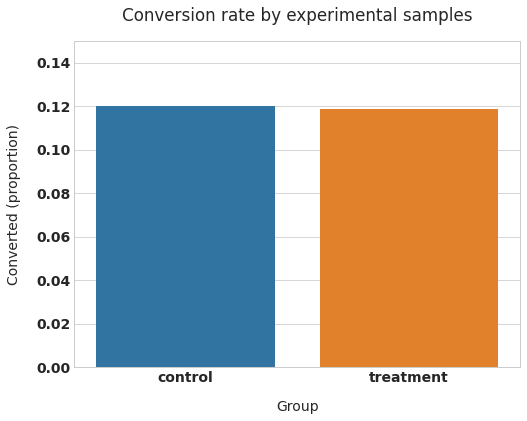

In [11]:
plt.figure(figsize=(8,6));
sns.barplot(x='group', y='converted', data=df, ci=False);

plt.ylim(0, 0.15);
plt.title('Conversion rate by experimental samples', pad=20)
plt.xlabel('Group', labelpad=15);
plt.ylabel('Converted (proportion)', labelpad=15);

In [12]:
sessions = df['user_id'].value_counts(ascending=False)
duplicate_users = sessions[sessions > 1].count()
print(f'There are {duplicate_users} users that appear multiple times in the dataset')

There are 0 users that appear multiple times in the dataset


In [13]:
effect_size = sms.proportion_effectsize(cr_control, cr_test)    # Calculating effect size based on our expected rates

required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=power, 
    alpha=alpha, 
    ratio=1
    )                                                  # Calculating sample size needed

required_n = ceil(required_n)                          # Rounding up to next whole number                          

print(required_n)

4433


* Our data frame more then need, we try check out hypothesis

In [14]:

control_results = df[(df.group == 'control') & (df.variants == 'standard')].converted
treatment_results = df[(df.group == 'treatment') & (df.variants == 'svm_ensemble_v_1_22')].converted

n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=alpha)

print(f'Z-statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'CI 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'CI 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')


Z-statistic: 1.31
p-value: 0.190
CI 95% for control group: [0.119, 0.122]
CI 95% for treatment group: [0.117, 0.120]


* Since our p-value=0.19 is way above our α=0.05 threshold, we cannot reject the Null hypothesis Hₒ, which means that our new design did not perform significantly different (let alone better) than our old one 

# 2a. Check hypothesis for registered users

In [15]:
piv_tab = pd.pivot_table(df, values='converted', index=['user_type', 'group'],
                      columns='variants', aggfunc=[np.sum, np.mean, len], observed=True)
piv_tab

sum                          mean  \
variants                  standard svm_ensemble_v_1_22  standard   
user_type       group                                              
new_user        control       8800                 105  0.120894   
                treatment      135                8504  0.134195   
registered_user control       8689                 129  0.119876   
                treatment      115                8760  0.119917   

                                                   len                      
variants                  svm_ensemble_v_1_22 standard svm_ensemble_v_1_22  
user_type       group                                                       
new_user        control              0.109489    72791                 959  
                treatment            0.117326     1006               72482  
registered_user control              0.133127    72483                 969  
                treatment            0.120282      959               72829

In [16]:
pd.crosstab(df[df.user_type == 'registered_user']['group'], df[df.user_type == 'registered_user']['variants'])

variants,standard,svm_ensemble_v_1_22
group,,
control,72483,969
treatment,959,72829


In [17]:
cr_ou_control = df[(df.user_type == 'registered_user') & (df.group == 'control') & (df.variants == 'standard')].converted.mean()
cr_ou_control

0.11987638480747209

In [18]:
cr_ou_test = df[(df.user_type == 'registered_user') & (df.group == 'treatment') & (df.variants == 'svm_ensemble_v_1_22')].converted.mean()
cr_ou_test

0.12028175589394334

* We see difference conversation rates control and treatment group small.

In [19]:
effect_size_old = sms.proportion_effectsize(cr_control, cr_test)    # Calculating effect size based on our expected rates

required_n_old = sms.NormalIndPower().solve_power(
    effect_size_old, 
    power=power, 
    alpha=alpha, 
    ratio=1
    )                                                  # Calculating sample size needed

required_n_old = ceil(required_n_old)                          # Rounding up to next whole number                          

print(required_n_old)

4433


* Our data frame more then need, we try check out hypothesis

In [20]:

control_old_user = df[(df.group == 'control') & (df.variants == 'standard') & (df.user_type == 'registered_user')].converted
treatment_old_user = df[(df.group == 'treatment') & (df.variants == 'svm_ensemble_v_1_22') & (df.user_type == 'registered_user')].converted

n_con = control_old_user.count()
n_treat = treatment_old_user.count()
successes = [control_old_user.sum(), treatment_old_user.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=alpha)

print(f'Z-statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'CI 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'CI 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

Z-statistic: -0.24
p-value: 0.812
CI 95% for control group: [0.118, 0.122]
CI 95% for treatment group: [0.118, 0.123]


* Since our p-value=0.812 is way above our α=0.05 threshold, we cannot reject the Null hypothesis Hₒ, which means that our new design did not perform significantly different (let alone better) than our old one

# 2b. Check hypothesis for new users

In [21]:
pd.crosstab(df[df.user_type == 'new_user']['group'], df[df.user_type == 'new_user']['variants'])

variants,standard,svm_ensemble_v_1_22
group,,
control,72791,959
treatment,1006,72482


In [22]:
cr_nu_control = df[(df.user_type == 'new_user') & (df.group == 'control') & (df.variants == 'standard')].converted.mean()
cr_nu_control

0.12089406657416439

In [23]:
cr_nu_test = df[(df.user_type == 'new_user') & (df.group == 'treatment') & (df.variants == 'svm_ensemble_v_1_22')].converted.mean()
cr_nu_test

0.11732568085869595

* We see difference conversation rates control and treatment group small.

In [24]:
effect_size_new = sms.proportion_effectsize(cr_control, cr_test)    # Calculating effect size based on our expected rates

required_n_new = sms.NormalIndPower().solve_power(
    effect_size_new, 
    power=power, 
    alpha=alpha, 
    ratio=1
    )                                                  # Calculating sample size needed

required_n_new = ceil(required_n_new)                          # Rounding up to next whole number                          

print(required_n_new)

4433


* Our data frame more then need, we try check out hypothesis

In [25]:

control_new_user = df[(df.group == 'control') & (df.variants == 'standard') & (df.user_type == 'new_user')].converted
treatment_new_user = df[(df.group == 'treatment') & (df.variants == 'svm_ensemble_v_1_22') & (df.user_type == 'new_user')].converted

n_con = control_new_user.count()
n_treat = treatment_new_user.count()
successes = [control_new_user.sum(), treatment_new_user.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=alpha)

print(f'Z-statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'CI 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'CI 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')


Z-statistic: 2.10
p-value: 0.036
CI 95% for control group: [0.119, 0.123]
CI 95% for treatment group: [0.115, 0.120]


* Since our p-value = 0.036 is less than our threshold α = 0.05, we can reject the null hypothesis Hₒ, meaning that our new design was different than our old one for new users.